## **Your challenge**

In a new notebook, apply everything you have learned here to the Housing project, following the Learning platform.

### Libraries and data

In [1]:
import ctypes # beeper
import pandas as pd
from sklearn import set_config
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

set_config(transform_output='pandas')

# reading
data = pd.read_csv('data/housing_iteration_5_classification.zip')
X_data = data.drop(
    columns=[
        'Neighborhood', 'HouseStyle'
        , 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Functional'
        , 'GarageFinish', 'MiscFeature', 'SaleCondition'])
# reading
data_competition = pd.read_csv('data/classification_competition_test_set.zip').set_index('Id')
X_data_competition = data_competition.drop(
    columns=[
        'Neighborhood', 'HouseStyle'
        , 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Functional'
        , 'GarageFinish', 'MiscFeature', 'SaleCondition'])

# X and y creation
X = X_data
y = X.pop('Expensive')

# # Feature Engineering
# X.loc[:, 'Cabin'] = X.Cabin.str[0]

# # data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=123)

In [2]:
data.columns

Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'Expensive',
       'MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir',
       'Foundation', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'FireplaceQu',
       'MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt',
       'GarageArea', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'MiscVal',
       'MoSold', 'YrSold', 'Id', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrTyp

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 71 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotArea        1460 non-null   int64  
 1   LotFrontage    1201 non-null   float64
 2   TotalBsmtSF    1460 non-null   int64  
 3   BedroomAbvGr   1460 non-null   int64  
 4   Fireplaces     1460 non-null   int64  
 5   PoolArea       1460 non-null   int64  
 6   GarageCars     1460 non-null   int64  
 7   WoodDeckSF     1460 non-null   int64  
 8   ScreenPorch    1460 non-null   int64  
 9   MSZoning       1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  Heating        1460 non-null   object 
 12  Street         1460 non-null   object 
 13  CentralAir     1460 non-null   object 
 14  Foundation     1460 non-null   object 
 15  ExterQual      1460 non-null   object 
 16  ExterCond      1460 non-null   object 
 17  BsmtQual       1423 non-null   object 
 18  BsmtCond

In [4]:
# selecting non-numerical columns
X_categorical = X_train.select_dtypes(exclude='number').columns
X_numerical = X_train.select_dtypes(include='number').columns

X_categorical

Index(['MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir',
       'Foundation', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'FireplaceQu', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl', 'BsmtFinType2',
       'HeatingQC', 'Electrical', 'GarageType', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'SaleType'],
      dtype='object')

#### Sort categorical columns

##### Batch #01

In [5]:
mszoning_order = ['RP', 'RL', 'RM', 'RH', 'FV', 'C (all)', 'A', 'I', 'NA']		
# MSZoning: Identifies the general zoning classification of the sale.
#     A	Agriculture
#     C	Commercial
#     FV	Floating Village Residential
#     I	Industrial
#     RH	Residential High Density
#     RL	Residential Low Density
#     RP	Residential Low Density Park 
#     RM	Residential Medium Density
data_competition['MSZoning'].value_counts()

MSZoning
RL         1114
RM          242
FV           74
C (all)      15
RH           10
Name: count, dtype: int64

In [6]:
condition1_order = ['PosA', 'PosN', 'Norm', 'Artery', 'Feedr', ['RRAn', 'RRAe'], ['RRNn', 'RRNe']]
condition1_order = ['PosA', 'PosN', 'Norm', 'Artery', 'Feedr', 'RRAn', 'RRAe', 'RRNn', 'RRNe']
# Condition1: Proximity to various conditions
#     Artery	Adjacent to arterial street
#     Feedr	Adjacent to feeder street	
#     Norm	Normal	
#     RRNn	Within 200' of North-South Railroad
#     RRAn	Adjacent to North-South Railroad
#     PosN	Near positive off-site feature--park, greenbelt, etc.
#     PosA	Adjacent to postive off-site feature
#     RRNe	Within 200' of East-West Railroad
#     RRAe	Adjacent to East-West Railroad
data_competition['Condition1'].value_counts()

Condition1
Norm      1251
Feedr       83
Artery      44
RRAn        24
PosN        20
RRAe        17
PosA        12
RRNe         4
RRNn         4
Name: count, dtype: int64

In [7]:
heating_order = ['GasW', 'OthW', 'GasA', 'Floor', 'Wall', 'Grav']
# Heating: Type of heating
#     Floor	Floor Furnace
#     GasA	Gas forced warm air furnace
#     GasW	Gas hot water or steam heat
#     Grav	Gravity furnace	
#     OthW	Hot water or steam heat other than gas
#     Wall	Wall furnace
data_competition['Heating'].value_counts()

Heating
GasA    1446
GasW       9
Grav       2
Wall       2
Name: count, dtype: int64

In [8]:
street_order = ['Pave', 'Grvl']
# Street: Type of road access to property
#        Grvl	Gravel	
#        Pave	Paved
data_competition['Street'].value_counts()

Street
Pave    1453
Grvl       6
Name: count, dtype: int64

In [9]:
centralair_order = ['Y', 'N']
# CentralAir: Central air conditioning
#        N	No
#        Y	Yes
data_competition['CentralAir'].value_counts()

CentralAir
Y    1358
N     101
Name: count, dtype: int64

In [10]:
foundation_order = ['PConc', 'CBlock', 'BrkTil', 'Stone', 'Slab', 'Wood']
# Foundation: Type of foundation
#        BrkTil	Brick & Tile
#        CBlock	Cinder Block
#        PConc	Poured Contrete	
#        Slab	Slab
#        Stone	Stone
#        Wood	Wood
data_competition['Foundation'].value_counts()

Foundation
PConc     661
CBlock    601
BrkTil    165
Slab       25
Stone       5
Wood        2
Name: count, dtype: int64

In [11]:
exterqual_order = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
# ExterQual: Evaluates the quality of the material on the exterior 
#        Ex	Excellent
#        Gd	Good
#        TA	Average/Typical
#        Fa	Fair
#        Po	Poor
data_competition['ExterQual'].value_counts()

ExterQual
TA    892
Gd    491
Ex     55
Fa     21
Name: count, dtype: int64

In [12]:
extercond_order = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
# ExterCond: Evaluates the present condition of the material on the exterior
#        Ex	Excellent
#        Gd	Good
#        TA	Average/Typical
#        Fa	Fair
#        Po	Poor
data_competition['ExterCond'].value_counts()

ExterCond
TA    1256
Gd     153
Fa      39
Ex       9
Po       2
Name: count, dtype: int64

In [13]:
bsmtqual_order = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
# BsmtQual: Evaluates the height of the basement
#        Ex	Excellent (100+ inches)	
#        Gd	Good (90-99 inches)
#        TA	Typical (80-89 inches)
#        Fa	Fair (70-79 inches)
#        Po	Poor (<70 inches
#        NA	No Basement
data_competition['BsmtQual'].value_counts()

BsmtQual
TA    634
Gd    591
Ex    137
Fa     53
Name: count, dtype: int64

In [14]:
bsmtcond_order = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
# BsmtCond: Evaluates the general condition of the basement
#        Ex	Excellent
#        Gd	Good
#        TA	Typical - slight dampness allowed
#        Fa	Fair - dampness or some cracking or settling
#        Po	Poor - Severe cracking, settling, or wetness
#        NA	No Basement
data_competition['BsmtCond'].value_counts()

BsmtCond
TA    1295
Fa      59
Gd      57
Po       3
Name: count, dtype: int64

##### Batch #02

In [15]:
bsmtexposure_order = ['Gd', 'Av', 'Mn', 'No', 'NA']
# BsmtExposure: Refers to walkout or garden level walls
#        Gd	Good Exposure
#        Av	Average Exposure (split levels or foyers typically score average or above)	
#        Mn	Mimimum Exposure
#        No	No Exposure
#        NA	No Basement
data_competition['BsmtExposure'].value_counts()

BsmtExposure
No    951
Av    197
Gd    142
Mn    125
Name: count, dtype: int64

In [16]:
bsmtfintype1_order = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']
# BsmtFinType1: Rating of basement finished area
#        GLQ	Good Living Quarters
#        ALQ	Average Living Quarters
#        BLQ	Below Average Living Quarters	
#        Rec	Average Rec Room
#        LwQ	Low Quality
#        Unf	Unfinshed
#        NA	No Basement
data_competition['BsmtFinType1'].value_counts()

BsmtFinType1
GLQ    431
Unf    421
ALQ    209
Rec    155
BLQ    121
LwQ     80
Name: count, dtype: int64

In [17]:
kitchenqual_order = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
# KitchenQual: Kitchen quality
#        Ex	Excellent
#        Gd	Good
#        TA	Typical/Average
#        Fa	Fair
#        Po	Poor
data_competition['KitchenQual'].value_counts()

KitchenQual
TA    757
Gd    565
Ex    105
Fa     31
Name: count, dtype: int64

In [18]:
fireplacequ_order = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
# FireplaceQu: Fireplace quality
#        Ex	Excellent - Exceptional Masonry Fireplace
#        Gd	Good - Masonry Fireplace in main level
#        TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
#        Fa	Fair - Prefabricated Fireplace in basement
#        Po	Poor - Ben Franklin Stove
#        NA	No Fireplace
data_competition['FireplaceQu'].value_counts()

FireplaceQu
Gd    364
TA    279
Fa     41
Po     26
Ex     19
Name: count, dtype: int64

In [19]:
alley_order = ['Pave', 'Grvl', 'NA']
# Alley: Type of alley access to property
#        Grvl	Gravel
#        Pave	Paved
#        NA 	No alley access
data_competition['Alley'].value_counts()

Alley
Grvl    70
Pave    37
Name: count, dtype: int64

In [20]:
lotshape_order = ['Reg', 'IR1', 'IR2', 'IR3']
# LotShape: General shape of property
#        Reg	Regular	
#        IR1	Slightly irregular
#        IR2	Moderately Irregular
#        IR3	Irregular
data_competition['Alley'].value_counts()

Alley
Grvl    70
Pave    37
Name: count, dtype: int64

In [21]:
landcontour_order = ['Lvl', 'Bnk', 'HLS', 'Low']
# LandContour: Flatness of the property
#        Lvl	Near Flat/Level	
#        Bnk	Banked - Quick and significant rise from street grade to building
#        HLS	Hillside - Significant slope from side to side
#        Low	Depression
data_competition['Alley'].value_counts()

Alley
Grvl    70
Pave    37
Name: count, dtype: int64

In [22]:
utilities_order = ['AllPub', 'NoSewr', 'NoSeWa', 'ELO', 'NA']
# Utilities: Type of utilities available
#        AllPub	All public Utilities (E,G,W,& S)	
#        NoSewr	Electricity, Gas, and Water (Septic Tank)
#        NoSeWa	Electricity and Gas Only
#        ELO	Electricity only	
data_competition['Utilities'].value_counts()

Utilities
AllPub    1457
Name: count, dtype: int64

In [23]:
lotconfig_order = ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3']
# LotConfig: Lot configuration
#        Inside	Inside lot
#        Corner	Corner lot
#        CulDSac	Cul-de-sac
#        FR2	Frontage on 2 sides of property
#        FR3	Frontage on 3 sides of property	
data_competition['LotConfig'].value_counts()

LotConfig
Inside     1081
Corner      248
CulDSac      82
FR2          38
FR3          10
Name: count, dtype: int64

In [24]:
landslope_order = ['Gtl', 'Mod', 'Sev']
# LandSlope: Slope of property
		
#        Gtl	Gentle slope
#        Mod	Moderate Slope	
#        Sev	Severe Slope
data_competition['LandSlope'].value_counts()

LandSlope
Gtl    1396
Mod      60
Sev       3
Name: count, dtype: int64

##### Batch #03

In [25]:
# Neighborhood

In [26]:
condition2_order = ['PosA', 'PosN', 'Norm', 'Artery', 'Feedr', 'RRAn', 'RRAe', 'RRNn', 'RRNe']
# Condition2: Proximity to various conditions
#     Artery	Adjacent to arterial street
#     Feedr	Adjacent to feeder street	
#     Norm	Normal	
#     RRNn	Within 200' of North-South Railroad
#     RRAn	Adjacent to North-South Railroad
#     PosN	Near positive off-site feature--park, greenbelt, etc.
#     PosA	Adjacent to postive off-site feature
#     RRNe	Within 200' of East-West Railroad
#     RRAe	Adjacent to East-West Railroad
data_competition['Condition2'].value_counts()

Condition2
Norm      1444
Feedr        7
PosA         3
Artery       3
PosN         2
Name: count, dtype: int64

In [27]:
bldgtype_order = ['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE', 'TwnhsI']
# BldgType: Type of dwelling
#        1Fam	Single-family Detached	
#        2FmCon	Two-family Conversion; originally built as one-family dwelling
#        Duplx	Duplex
#        TwnhsE	Townhouse End Unit
#        TwnhsI	Townhouse Inside Unit
data_competition['BldgType'].value_counts()

BldgType
1Fam      1205
TwnhsE     113
Duplex      57
Twnhs       53
2fmCon      31
Name: count, dtype: int64

In [28]:
# HouseStyle

In [29]:
roofstyle_order = ['Flat', 'Gable', 'Gambrel', 'Hip', 'Mansard', 'Shed']
# RoofStyle: Type of roof
#        Flat	Flat
#        Gable	Gable
#        Gambrel	Gabrel (Barn)
#        Hip	Hip
#        Mansard	Mansard
#        Shed	Shed
data_competition['RoofStyle'].value_counts()

RoofStyle
Gable      1169
Hip         265
Gambrel      11
Flat          7
Mansard       4
Shed          3
Name: count, dtype: int64

In [30]:
roofmatl_order = ['ClyTile', 'CompShg', 'Membran', 'Metal', 'Roll', 'Tar&Grv', 'WdShake', 'WdShngl']
# RoofMatl: Roof material
#        ClyTile	Clay or Tile
#        CompShg	Standard (Composite) Shingle
#        Membran	Membrane
#        Metal	Metal
#        Roll	Roll
#        Tar&Grv	Gravel & Tar
#        WdShake	Wood Shakes
#        WdShngl	Wood Shingles
data_competition['RoofMatl'].value_counts()

RoofMatl
CompShg    1442
Tar&Grv      12
WdShake       4
WdShngl       1
Name: count, dtype: int64

In [31]:
# Exterior1st

In [32]:
# Exterior2nd

In [33]:
# MasVnrType

In [34]:
bsmtfintype2_order = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']
# BsmtFinType1: Rating of basement finished area
#        GLQ	Good Living Quarters
#        ALQ	Average Living Quarters
#        BLQ	Below Average Living Quarters	
#        Rec	Average Rec Room
#        LwQ	Low Quality
#        Unf	Unfinshed
#        NA	No Basement
data_competition['BsmtFinType2'].value_counts()

BsmtFinType2
Unf    1237
Rec      51
LwQ      41
BLQ      35
ALQ      33
GLQ      20
Name: count, dtype: int64

##### Batch #04

In [35]:
heatingqc_order = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
# HeatingQC: Heating quality and condition

#        Ex	Excellent
#        Gd	Good
#        TA	Average/Typical
#        Fa	Fair
#        Po	Poor
data_competition['HeatingQC'].value_counts()

HeatingQC
Ex    752
TA    429
Gd    233
Fa     43
Po      2
Name: count, dtype: int64

In [36]:
electrical_order = ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix', 'NA']
# Electrical: Electrical system
#        SBrkr	Standard Circuit Breakers & Romex
#        FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
#        FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
#        FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
#        Mix	Mixed
data_competition['Electrical'].value_counts()

Electrical
SBrkr    1337
FuseA      94
FuseF      23
FuseP       5
Name: count, dtype: int64

In [37]:
# Functional

In [38]:
garagetype_order = ['2Types', 'Attchd', 'Basment', 'BuiltIn', 'CarPort', 'Detchd', 'NA']
# GarageType: Garage location
		
#        2Types	More than one type of garage
#        Attchd	Attached to home
#        Basment	Basement Garage
#        BuiltIn	Built-In (Garage part of house - typically has room above garage)
#        CarPort	Car Port
#        Detchd	Detached from home
#        NA	No Garage
data_competition['GarageType'].value_counts()

GarageType
Attchd     853
Detchd     392
BuiltIn     98
Basment     17
2Types      17
CarPort      6
Name: count, dtype: int64

In [39]:
# GarageFinish

In [40]:
garagequal_order = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
# GarageQual: Garage quality

#        Ex	Excellent
#        Gd	Good
#        TA	Typical/Average
#        Fa	Fair
#        Po	Poor
#        NA	No Garage
data_competition['GarageQual'].value_counts()

GarageQual
TA    1293
Fa      76
Gd      10
Po       2
Name: count, dtype: int64

In [41]:
garagecond_order = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
# GarageCond: Garage condition
#        Ex	Excellent
#        Gd	Good
#        TA	Typical/Average
#        Fa	Fair
#        Po	Poor
#        NA	No Garage
data_competition['GarageCond'].value_counts()

GarageCond
TA    1328
Fa      39
Po       7
Gd       6
Ex       1
Name: count, dtype: int64

In [42]:
paveddrive_order = ['Y', 'P', 'N']
# PavedDrive: Paved driveway
#        Y	Paved 
#        P	Partial Pavement
#        N	Dirt/Gravel
data_competition['PavedDrive'].value_counts()

PavedDrive
Y    1301
N     126
P      32
Name: count, dtype: int64

In [43]:
poolqc_order = ['Ex', 'Gd', 'TA', 'Fa', 'NA']
# PoolQC: Pool quality
#        Ex	Excellent
#        Gd	Good
#        TA	Average/Typical
#        Fa	Fair
#        NA	No Pool
data_competition['PoolQC'].value_counts()

PoolQC
Ex    2
Gd    1
Name: count, dtype: int64

In [44]:
fence_order = ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA']
# Fence: Fence quality
#        GdPrv	Good Privacy
#        MnPrv	Minimum Privacy
#        GdWo	Good Wood
#        MnWw	Minimum Wood/Wire
#        NA	No Fence
data_competition['Fence'].value_counts()

Fence
MnPrv    172
GdPrv     59
GdWo      58
MnWw       1
Name: count, dtype: int64

##### Batch #05

In [45]:
# MiscFeature

In [46]:
salestype_order = ['WD', 'CWD', 'VWD', 'New', 'COD', 'Con', 'ConLw', 'ConLI', 'ConLD', 'Oth', 'NA']
# SaleType: Type of sale
#        WD 	Warranty Deed - Conventional
#        CWD	Warranty Deed - Cash
#        VWD	Warranty Deed - VA Loan
#        New	Home just constructed and sold
#        COD	Court Officer Deed/Estate
#        Con	Contract 15% Down payment regular terms
#        ConLw	Contract Low Down payment and low interest
#        ConLI	Contract Low Interest
#        ConLD	Contract Low Down
#        Oth	Other
data_competition['SaleType'].value_counts()

SaleType
WD       1258
New       117
COD        44
ConLD      17
CWD         8
Oth         4
ConLI       4
ConLw       3
Con         3
Name: count, dtype: int64

In [47]:
# SaleCondition

# SaleCondition: Condition of sale

#        Normal	Normal Sale
#        Abnorml	Abnormal Sale -  trade, foreclosure, short sale
#        AdjLand	Adjoining Land Purchase
#        Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
#        Family	Sale between family members
#        Partial	Home was not completed when last assessed (associated with New Homes)

### Knowing data

In [48]:
data.head()

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,8450,65.0,856,3,0,0,2,0,0,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,9600,80.0,1262,3,1,0,2,298,0,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,11250,68.0,920,3,1,0,2,0,0,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,9550,60.0,756,3,1,0,3,0,0,0,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,14260,84.0,1145,4,1,0,3,192,0,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotArea        1460 non-null   int64  
 1   LotFrontage    1201 non-null   float64
 2   TotalBsmtSF    1460 non-null   int64  
 3   BedroomAbvGr   1460 non-null   int64  
 4   Fireplaces     1460 non-null   int64  
 5   PoolArea       1460 non-null   int64  
 6   GarageCars     1460 non-null   int64  
 7   WoodDeckSF     1460 non-null   int64  
 8   ScreenPorch    1460 non-null   int64  
 9   Expensive      1460 non-null   int64  
 10  MSZoning       1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Heating        1460 non-null   object 
 13  Street         1460 non-null   object 
 14  CentralAir     1460 non-null   object 
 15  Foundation     1460 non-null   object 
 16  ExterQual      1460 non-null   object 
 17  ExterCond      1460 non-null   object 
 18  BsmtQual

In [50]:
X_numerical

Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'MiscVal', 'MoSold',
       'YrSold', 'Id'],
      dtype='object')

In [51]:
X_categorical

Index(['MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir',
       'Foundation', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'FireplaceQu', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl', 'BsmtFinType2',
       'HeatingQC', 'Electrical', 'GarageType', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'SaleType'],
      dtype='object')

In [52]:
X_train

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,MSZoning,...,BsmtFinType2,HeatingQC,Electrical,GarageType,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,SaleType
662,13560,120.0,1392,2,2,0,2,0,0,RL,...,Unf,Gd,SBrkr,Attchd,TA,TA,Y,NaN,NaN,WD
1452,3675,35.0,547,2,0,0,2,0,0,RM,...,Unf,Gd,SBrkr,Basment,TA,TA,Y,NaN,NaN,WD
497,9120,60.0,1026,4,0,0,1,0,0,RL,...,Unf,Ex,SBrkr,Detchd,TA,TA,N,NaN,GdPrv,WD
413,8960,56.0,1008,2,1,0,2,0,0,RM,...,Unf,Gd,FuseA,Detchd,TA,TA,Y,NaN,NaN,WD
791,11333,NaN,1029,3,2,0,2,120,0,RL,...,Unf,TA,SBrkr,Attchd,TA,TA,Y,NaN,NaN,WD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,7800,66.0,912,2,0,0,1,0,0,RL,...,LwQ,TA,SBrkr,Attchd,TA,TA,Y,NaN,NaN,WD
460,8004,75.0,832,3,0,0,2,0,0,FV,...,Unf,Ex,SBrkr,BuiltIn,TA,TA,Y,NaN,NaN,New
189,4923,41.0,1593,0,1,0,2,0,224,RL,...,Unf,Ex,SBrkr,Attchd,TA,TA,Y,NaN,NaN,WD
1402,6762,64.0,1286,2,1,0,2,168,0,RL,...,Unf,Ex,SBrkr,Attchd,TA,TA,Y,NaN,NaN,New


### Transformers and Classifier pick

In [53]:
pipe_numerical_mean = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='mean')) #, ('standard_scaler', StandardScaler())
    ])
pipe_numerical = Pipeline([
    ('simple_imputer', SimpleImputer(fill_value=0)) #, ('standard_scaler', StandardScaler())
    ])

pipe_categorical = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='constant', fill_value='NA'))
    , ('order_encoder', OrdinalEncoder(categories=[
    mszoning_order, condition1_order, heating_order, street_order, centralair_order
    , foundation_order, exterqual_order, extercond_order, bsmtqual_order, bsmtcond_order
    , bsmtexposure_order, bsmtfintype1_order, kitchenqual_order, fireplacequ_order, alley_order
    , lotshape_order , landcontour_order, utilities_order, lotconfig_order, landslope_order
    , condition2_order, bldgtype_order, roofstyle_order, roofmatl_order, bsmtfintype2_order
    , heatingqc_order, electrical_order, garagetype_order, garagequal_order, garagecond_order
    , paveddrive_order, poolqc_order, fence_order, salestype_order]))])
classifiers = [
    ("decision_tree", DecisionTreeClassifier()),
    ("random_forest", RandomForestClassifier()),
    ("logistic_regression", LogisticRegression()),
    ("knn", KNeighborsClassifier())
]

pipes = ColumnTransformer([
    ('num_imputer_01', pipe_numerical, ['LotArea'])
    , ('num_imputer_02', pipe_numerical, ['LotFrontage'])
    , ('num_imputer_03', pipe_numerical, ['TotalBsmtSF'])
    , ('num_imputer_04', pipe_numerical, ['BedroomAbvGr'])
    , ('num_imputer_05', pipe_numerical, ['Fireplaces'])
    , ('num_imputer_06', pipe_numerical, ['PoolArea'])
    , ('num_imputer_07', pipe_numerical, ['GarageCars'])
    , ('num_imputer_08', pipe_numerical, ['WoodDeckSF'])
    , ('num_imputer_09', pipe_numerical, ['ScreenPorch'])
    , ('num_imputer_10', pipe_numerical, ['MSSubClass'])
    , ('num_imputer_11', pipe_numerical, ['OverallQual'])
    , ('num_imputer_12', pipe_numerical, ['OverallCond'])
    , ('num_imputer_13', pipe_numerical, ['YearBuilt'])
    , ('num_imputer_14', pipe_numerical, ['YearRemodAdd'])
    , ('num_imputer_15', pipe_numerical, ['MasVnrArea'])
    , ('num_imputer_16', pipe_numerical, ['BsmtFinSF1'])
    , ('num_imputer_17', pipe_numerical, ['BsmtFinSF2'])
    , ('num_imputer_18', pipe_numerical, ['BsmtUnfSF'])
    , ('num_imputer_19', pipe_numerical, ['1stFlrSF'])
    , ('num_imputer_20', pipe_numerical, ['2ndFlrSF'])
    , ('num_imputer_21', pipe_numerical, ['LowQualFinSF'])
    , ('num_imputer_22', pipe_numerical, ['GrLivArea'])
    , ('num_imputer_23', pipe_numerical, ['BsmtFullBath'])
    , ('num_imputer_24', pipe_numerical, ['BsmtHalfBath'])
    , ('num_imputer_25', pipe_numerical, ['FullBath'])
    , ('num_imputer_26', pipe_numerical, ['HalfBath'])
    , ('num_imputer_27', pipe_numerical, ['KitchenAbvGr'])
    , ('num_imputer_28', pipe_numerical, ['TotRmsAbvGrd'])
    , ('num_imputer_29', pipe_numerical, ['GarageYrBlt'])
    , ('num_imputer_30', pipe_numerical, ['GarageArea'])
    , ('num_imputer_31', pipe_numerical, ['OpenPorchSF'])
    , ('num_imputer_32', pipe_numerical, ['EnclosedPorch'])
    , ('num_imputer_33', pipe_numerical, ['3SsnPorch'])
    , ('num_imputer_34', pipe_numerical, ['MiscVal'])
    , ('num_imputer_35', pipe_numerical, ['MoSold'])
    , ('num_imputer_36', pipe_numerical, ['YrSold'])
    , ('cat_imputer_order', pipe_categorical, X_categorical)
])# , remainder='passthrough')
pipeline = Pipeline([('preprocessor', pipes), ('classifier', DecisionTreeClassifier())])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_imputer_01',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0))]),
                                                  ['LotArea']),
                                                 ('num_imputer_02',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0))]),
                                                  ['LotFrontage']),
                                                 ('num_imputer_03',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0))]),
                                                  ['Total...
                                                  ['KitchenAbvGr']),
                                                 ('num_imputer_28',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0))]),
                                                  ['TotRmsAbvGrd']),
                                                 ('num_imputer_29',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0))]),
                                                  ['GarageYrBlt']),
                                                 ('num_imputer_30',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0))]),
                                                  ['GarageArea']), ...])),
                ('classifier', DecisionTreeClassifier())])

In [ ]:
pipe_numerical_mean.fit_transform(X_train).columns

### Grid search

In [54]:
pipeline.named_steps['preprocessor'].fit_transform(X_train).columns

Index(['num_imputer_01__LotArea', 'num_imputer_02__LotFrontage',
       'num_imputer_03__TotalBsmtSF', 'num_imputer_04__BedroomAbvGr',
       'num_imputer_05__Fireplaces', 'num_imputer_06__PoolArea',
       'num_imputer_07__GarageCars', 'num_imputer_08__WoodDeckSF',
       'num_imputer_09__ScreenPorch', 'num_imputer_10__MSSubClass',
       'num_imputer_11__OverallQual', 'num_imputer_12__OverallCond',
       'num_imputer_13__YearBuilt', 'num_imputer_14__YearRemodAdd',
       'num_imputer_15__MasVnrArea', 'num_imputer_16__BsmtFinSF1',
       'num_imputer_17__BsmtFinSF2', 'num_imputer_18__BsmtUnfSF',
       'num_imputer_19__1stFlrSF', 'num_imputer_20__2ndFlrSF',
       'num_imputer_21__LowQualFinSF', 'num_imputer_22__GrLivArea',
       'num_imputer_23__BsmtFullBath', 'num_imputer_24__BsmtHalfBath',
       'num_imputer_25__FullBath', 'num_imputer_26__HalfBath',
       'num_imputer_27__KitchenAbvGr', 'num_imputer_28__TotRmsAbvGrd',
       'num_imputer_29__GarageYrBlt', 'num_imputer_30__Gara

In [55]:
pipeline.named_steps#['preprocessor']

{'preprocessor': ColumnTransformer(transformers=[('num_imputer_01',
                                  Pipeline(steps=[('simple_imputer',
                                                   SimpleImputer(fill_value=0))]),
                                  ['LotArea']),
                                 ('num_imputer_02',
                                  Pipeline(steps=[('simple_imputer',
                                                   SimpleImputer(fill_value=0))]),
                                  ['LotFrontage']),
                                 ('num_imputer_03',
                                  Pipeline(steps=[('simple_imputer',
                                                   SimpleImputer(fill_value=0))]),
                                  ['TotalBsmtSF']),
                                 ('num_imputer_04',
                                  Pipe...
                                                   SimpleImputer(fill_value=0))]),
                                  ['Kitchen

In [56]:
# define parameter grid
param_grid_rf = [
    # {
    #     'preprocessor__num_imputer3__simple_imputer__strategy':['mean', 'median']
    #     , 'classifier': [DecisionTreeClassifier()]
    #     ,'classifier__max_depth': range(4, 7, 1)
    #     , 'classifier__min_samples_leaf': range(2, 4, 1)
    #     , 'classifier__min_samples_split': range(2, 4, 1)
    #     , 'classifier__criterion': ['gini', 'entropy']}

    # # Parameters for Random Forest
    {
        'preprocessor__num_imputer_01__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_02__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_03__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_04__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_05__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_06__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_07__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_08__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_09__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_10__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_11__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_12__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_13__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_14__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_15__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_16__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_17__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_18__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_19__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_20__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_21__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_22__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_23__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_24__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_25__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_26__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_27__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_28__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_29__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_30__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_31__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_32__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_33__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_34__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_35__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_36__simple_imputer__strategy':['constant']
        , 'classifier': [RandomForestClassifier()]
        , 'classifier__n_estimators': range(200, 310, 20)
        # , 'classifier__max_depth': range(42, 47, 1) #[40, 450, ]
        # , 'classifier__min_samples_leaf': [1, 2, 3, 4]
        # , 'classifier__class_weight': ['balanced', None]
        # , 'classifier__ccp_alpha': [0, 0.000001, 0.00001]
        , 'classifier__max_features': ['sqrt', 'log2']
        }

    # # Parameters for Logistic Regression
    # {
    #     'preprocessor__num_imputer3__simple_imputer__strategy':['mean', 'median']
    #     , 'classifier': [LogisticRegression()]
    #     , 'classifier__penalty': ['l1', 'l2', 'elasticnet', None]
    #     , 'classifier__C': [0.09, 0.12, 0.15, 1, 5, 10
    #     , 'classifier__solver': ['liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}
    
    # Parameters for KNN
    # {
    #     'preprocessor__num_imputer_mean__simple_imputer__strategy':['mean', 'median', 'most_frequent', 'constant']
    #     , 'preprocessor__num_imputer_mean_median__simple_imputer__fill_value':[0]
    #     , 'classifier': [KNeighborsClassifier()]
    #     , 'classifier__n_neighbors': range(5, 50, 10)
    #     , 'classifier__weights': ['uniform', 'distance']
    #     , 'classifier__metric': ['minkowski', 'euclidean', 'non_euclidean', 'manhattan', 'chebyshev', 'l1', 'l2', 'haversine', 'cityblock']}
]

# define GridSearchCV
param_search_rf = GridSearchCV(pipeline,
                      param_grid_rf,
                      cv=StratifiedKFold(n_splits=10),
                      verbose=1)

param_search_rf.fit(X_train, y_train)

y_pred_rf = param_search_rf.best_estimator_.predict(X_train)
_ = ctypes.windll.kernel32.Beep(1000, 2000)
print(f'Accuracy: {accuracy_score(y_train, y_pred_rf):.4f}')
param_search_rf.best_params_

Fitting 10 folds for each of 12 candidates, totalling 120 fits


KeyboardInterrupt: 

In [184]:
# define parameter grid
param_grid_dt = [
    {
        'preprocessor__num_imputer_01__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_02__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_03__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_04__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_05__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_06__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_07__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_08__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_09__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_10__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_11__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_12__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_13__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_14__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_15__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_16__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_17__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_18__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_19__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_20__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_21__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_22__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_23__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_24__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_25__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_26__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_27__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_28__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_29__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_30__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_31__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_32__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_33__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_34__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_35__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_36__simple_imputer__strategy':['constant']
        , 'classifier': [DecisionTreeClassifier()]
        ,'classifier__max_depth': range(4, 7, 1)
        , 'classifier__min_samples_leaf': range(2, 4, 1)
        , 'classifier__min_samples_split': range(2, 4, 1)
        , 'classifier__criterion': ['gini', 'entropy']}

    # # Parameters for Logistic Regression
    # {
    #     'preprocessor__num_imputer3__simple_imputer__strategy':['mean', 'median']
    #     , 'classifier': [LogisticRegression()]
    #     , 'classifier__penalty': ['l1', 'l2', 'elasticnet', None]
    #     , 'classifier__C': [0.09, 0.12, 0.15, 1, 5, 10
    #     , 'classifier__solver': ['liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}
    
    # Parameters for KNN
    # {
    #     'preprocessor__num_imputer_mean__simple_imputer__strategy':['mean', 'median', 'most_frequent', 'constant']
    #     , 'preprocessor__num_imputer_mean_median__simple_imputer__fill_value':[0]
    #     , 'classifier': [KNeighborsClassifier()]
    #     , 'classifier__n_neighbors': range(5, 50, 10)
    #     , 'classifier__weights': ['uniform', 'distance']
    #     , 'classifier__metric': ['minkowski', 'euclidean', 'non_euclidean', 'manhattan', 'chebyshev', 'l1', 'l2', 'haversine', 'cityblock']}
]

# define GridSearchCV
param_search_dt = GridSearchCV(pipeline,
                      param_grid_dt,
                      cv=StratifiedKFold(n_splits=10),
                      verbose=1)

param_search_dt.fit(X_train, y_train)

y_pred_dt = param_search_dt.best_estimator_.predict(X_train)
_ = ctypes.windll.kernel32.Beep(1000, 2000)
print(f'Accuracy: {accuracy_score(y_train, y_pred_dt):.4f}')
param_search_dt.best_params_

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Accuracy: 0.9743


{'classifier': DecisionTreeClassifier(),
 'classifier__criterion': 'gini',
 'classifier__max_depth': 5,
 'classifier__min_samples_leaf': 3,
 'classifier__min_samples_split': 2,
 'preprocessor__num_imputer_01__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_02__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_03__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_04__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_05__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_06__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_07__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_08__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_09__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_10__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_11__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_12__simple_imputer__strategy': 'consta

In [185]:
# define parameter grid
param_grid_lr = [
    {
        'preprocessor__num_imputer_01__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_02__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_03__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_04__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_05__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_06__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_07__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_08__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_09__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_10__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_11__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_12__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_13__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_14__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_15__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_16__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_17__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_18__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_19__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_20__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_21__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_22__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_23__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_24__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_25__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_26__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_27__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_28__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_29__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_30__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_31__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_32__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_33__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_34__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_35__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_36__simple_imputer__strategy':['constant']
        , 'classifier': [LogisticRegression()]
        , 'classifier__penalty': ['l1', 'l2', 'elasticnet', None]
        , 'classifier__C': [0.09, 0.12, 0.15, 1, 5, 10]
        , 'classifier__solver': ['liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}
    
    # Parameters for KNN
    # {
    #     'preprocessor__num_imputer_mean__simple_imputer__strategy':['mean', 'median', 'most_frequent', 'constant']
    #     , 'preprocessor__num_imputer_mean_median__simple_imputer__fill_value':[0]
    #     , 'classifier': [KNeighborsClassifier()]
    #     , 'classifier__n_neighbors': range(5, 50, 10)
    #     , 'classifier__weights': ['uniform', 'distance']
    #     , 'classifier__metric': ['minkowski', 'euclidean', 'non_euclidean', 'manhattan', 'chebyshev', 'l1', 'l2', 'haversine', 'cityblock']}
]

# define GridSearchCV
param_search_lr = GridSearchCV(pipeline,
                      param_grid_lr,
                      cv=StratifiedKFold(n_splits=10),
                      verbose=1)

param_search_lr.fit(X_train, y_train)

y_pred_lr = param_search_lr.best_estimator_.predict(X_train)
_ = ctypes.windll.kernel32.Beep(1000, 2000)
print(f'Accuracy: {accuracy_score(y_train, y_pred_lr):.4f}')
param_search_lr.best_params_

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


c:\Users\Gastan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Gastan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Gastan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Gastan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Gastan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  

Accuracy: 0.9623


{'classifier': LogisticRegression(),
 'classifier__C': 0.12,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear',
 'preprocessor__num_imputer_01__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_02__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_03__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_04__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_05__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_06__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_07__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_08__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_09__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_10__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_11__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_12__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_13__simple_impute

In [ ]:
# define parameter grid
param_grid_knn = [
    {
        'preprocessor__num_imputer_01__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_02__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_03__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_04__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_05__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_06__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_07__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_08__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_09__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_10__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_11__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_12__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_13__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_14__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_15__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_16__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_17__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_18__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_19__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_20__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_21__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_22__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_23__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_24__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_25__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_26__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_27__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_28__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_29__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_30__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_31__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_32__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_33__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_34__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_35__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_36__simple_imputer__strategy':['constant']
        , 'classifier': [KNeighborsClassifier()]
        , 'classifier__n_neighbors': range(5, 50, 10)
        , 'classifier__weights': ['uniform', 'distance']
        , 'classifier__metric': ['manhattan']}
]

# define GridSearchCV
param_search_knn = GridSearchCV(pipeline,
                      param_grid_knn,
                      cv=StratifiedKFold(n_splits=10),
                      verbose=1)

param_search_knn.fit(X_train, y_train)

y_pred_knn = param_search_knn.best_estimator_.predict(X_train)
_ = ctypes.windll.kernel32.Beep(1000, 2000)
print(f'Accuracy: {accuracy_score(y_train, y_pred_knn):.4f}')
param_search_knn.best_params_

Fitting 10 folds for each of 90 candidates, totalling 900 fits


c:\Users\Gastan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Gastan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\Gastan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 472, in __call__
    return estimator.score(*args, **kwargs)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "c:\Users\Gastan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py", line 1197, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
           ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Gastan\AppData\Local\Programs\Python\Python3

Accuracy: 0.9469


{'classifier': KNeighborsClassifier(),
 'classifier__metric': 'manhattan',
 'classifier__n_neighbors': 5,
 'classifier__weights': 'uniform',
 'preprocessor__num_imputer_01__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_02__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_03__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_04__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_05__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_06__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_07__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_08__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_09__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_10__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_11__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_12__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_13_

In [187]:
# define parameter grid
param_grid_svc = [
    {
        'preprocessor__num_imputer_01__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_02__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_03__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_04__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_05__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_06__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_07__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_08__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_09__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_10__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_11__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_12__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_13__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_14__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_15__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_16__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_17__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_18__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_19__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_20__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_21__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_22__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_23__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_24__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_25__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_26__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_27__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_28__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_29__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_30__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_31__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_32__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_33__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_34__simple_imputer__strategy':['constant']
        , 'preprocessor__num_imputer_35__simple_imputer__strategy':['mean']
        , 'preprocessor__num_imputer_36__simple_imputer__strategy':['constant']
        , 'classifier': [SVC()]
        , 'classifier__C': [0.1, 0.5]
        , 'classifier__kernel': ['linear']
        , 'classifier__degree': [2]}
]

# define GridSearchCV
param_search_svc = GridSearchCV(pipeline,
                      param_grid_svc,
                      cv=StratifiedKFold(n_splits=5),
                      verbose=1)

param_search_svc.fit(X_train, y_train)

y_pred_svc = param_search_svc.best_estimator_.predict(X_train)
_ = ctypes.windll.kernel32.Beep(1000, 2000)
print(f'Accuracy: {accuracy_score(y_train, y_pred_svc):.4f}')
param_search_svc.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Accuracy: 0.9563


{'classifier': SVC(),
 'classifier__C': 0.1,
 'classifier__degree': 2,
 'classifier__kernel': 'linear',
 'preprocessor__num_imputer_01__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_02__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_03__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_04__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_05__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_06__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_07__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_08__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_09__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_10__simple_imputer__strategy': 'mean',
 'preprocessor__num_imputer_11__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_12__simple_imputer__strategy': 'constant',
 'preprocessor__num_imputer_13__simple_imputer__strategy': 'mean',
 

### Best model

In [188]:
best_rf = param_search_rf.best_estimator_
param_search_rf.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_imputer_01',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['LotArea']),
                                                 ('num_imputer_02',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['LotFrontage']),
                                                 ('num_imputer_03',
                                                  Pipeline(steps=[('simple_imputer...
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['TotRmsAbvGrd']),
                                                 ('num_imputer_29',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0))]),
                                                  ['GarageYrBlt']),
                                                 ('num_imputer_30',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['GarageArea']), ...])),
                ('classifier',
                 RandomForestClassifier(max_features='log2',
                                        n_estimators=260))])

In [189]:
best_dt = param_search_dt.best_estimator_
param_search_dt.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_imputer_01',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['LotArea']),
                                                 ('num_imputer_02',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['LotFrontage']),
                                                 ('num_imputer_03',
                                                  Pipeline(steps=[('simple_imputer...
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['TotRmsAbvGrd']),
                                                 ('num_imputer_29',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0))]),
                                                  ['GarageYrBlt']),
                                                 ('num_imputer_30',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['GarageArea']), ...])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=3))])

In [190]:
best_lr = param_search_lr.best_estimator_
param_search_lr.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_imputer_01',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['LotArea']),
                                                 ('num_imputer_02',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['LotFrontage']),
                                                 ('num_imputer_03',
                                                  Pipeline(steps=[('simple_imputer...
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['TotRmsAbvGrd']),
                                                 ('num_imputer_29',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0))]),
                                                  ['GarageYrBlt']),
                                                 ('num_imputer_30',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['GarageArea']), ...])),
                ('classifier',
                 LogisticRegression(C=0.12, penalty='l1', solver='liblinear'))])

In [191]:
best_knn = param_search_knn.best_estimator_
param_search_knn.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_imputer_01',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['LotArea']),
                                                 ('num_imputer_02',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['LotFrontage']),
                                                 ('num_imputer_03',
                                                  Pipeline(steps=[('simple_imputer...
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['TotRmsAbvGrd']),
                                                 ('num_imputer_29',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0))]),
                                                  ['GarageYrBlt']),
                                                 ('num_imputer_30',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['GarageArea']), ...])),
                ('classifier', KNeighborsClassifier(metric='manhattan'))])

In [192]:
best_svc = param_search_svc.best_estimator_
param_search_svc.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_imputer_01',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['LotArea']),
                                                 ('num_imputer_02',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['LotFrontage']),
                                                 ('num_imputer_03',
                                                  Pipeline(steps=[('simple_imputer...
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['TotRmsAbvGrd']),
                                                 ('num_imputer_29',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0))]),
                                                  ['GarageYrBlt']),
                                                 ('num_imputer_30',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['GarageArea']), ...])),
                ('classifier', SVC(C=0.1, degree=2, kernel='linear'))])

In [193]:
y_train_pred_rf = best_rf.predict(X_train)
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_rf):.4f}')
print(f'Recall: {recall_score(y_train, y_train_pred_rf):.4f}')
print(f'Precision: {precision_score(y_train, y_train_pred_rf):.4f}')
print(f'F1 score: {f1_score(y_train, y_train_pred_rf):.4f}')

Accuracy: 1.0000
Recall: 1.0000
Precision: 1.0000
F1 score: 1.0000


In [194]:
y_train_pred_dt = best_dt.predict(X_train)
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_dt):.4f}')
print(f'Recall: {recall_score(y_train, y_train_pred_dt):.4f}')
print(f'Precision: {precision_score(y_train, y_train_pred_dt):.4f}')
print(f'F1 score: {f1_score(y_train, y_train_pred_dt):.4f}')

Accuracy: 0.9743
Recall: 0.8735
Precision: 0.9416
F1 score: 0.9062


In [195]:
y_train_pred_lr = best_lr.predict(X_train)
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_lr):.4f}')
print(f'Recall: {recall_score(y_train, y_train_pred_lr):.4f}')
print(f'Precision: {precision_score(y_train, y_train_pred_lr):.4f}')
print(f'F1 score: {f1_score(y_train, y_train_pred_lr):.4f}')

Accuracy: 0.9623
Recall: 0.8133
Precision: 0.9122
F1 score: 0.8599


In [196]:
y_train_pred_knn = best_knn.predict(X_train)
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_knn):.4f}')
print(f'Recall: {recall_score(y_train, y_train_pred_knn):.4f}')
print(f'Precision: {precision_score(y_train, y_train_pred_knn):.4f}')
print(f'F1 score: {f1_score(y_train, y_train_pred_knn):.4f}')

Accuracy: 0.9469
Recall: 0.7108
Precision: 0.8939
F1 score: 0.7919


In [197]:
y_train_pred_svc = best_svc.predict(X_train)
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_svc):.4f}')
print(f'Recall: {recall_score(y_train, y_train_pred_svc):.4f}')
print(f'Precision: {precision_score(y_train, y_train_pred_svc):.4f}')
print(f'F1 score: {f1_score(y_train, y_train_pred_svc):.4f}')

Accuracy: 0.9563
Recall: 0.8253
Precision: 0.8616
F1 score: 0.8431


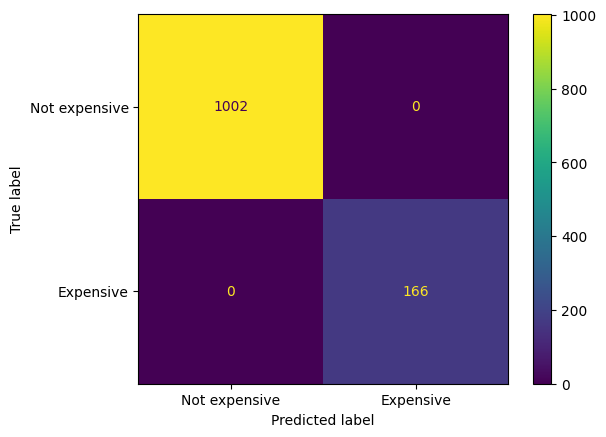

In [198]:
ConfusionMatrixDisplay.from_estimator(
    best_rf
    , X_train
    , y_train
    , display_labels=['Not expensive', 'Expensive']);

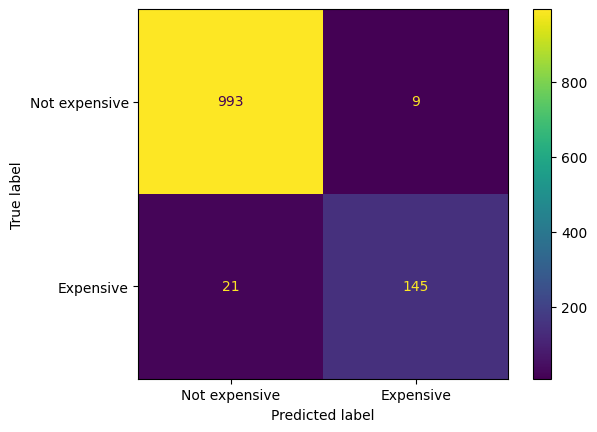

In [199]:
ConfusionMatrixDisplay.from_estimator(
    best_dt
    , X_train
    , y_train
    , display_labels=['Not expensive', 'Expensive']);

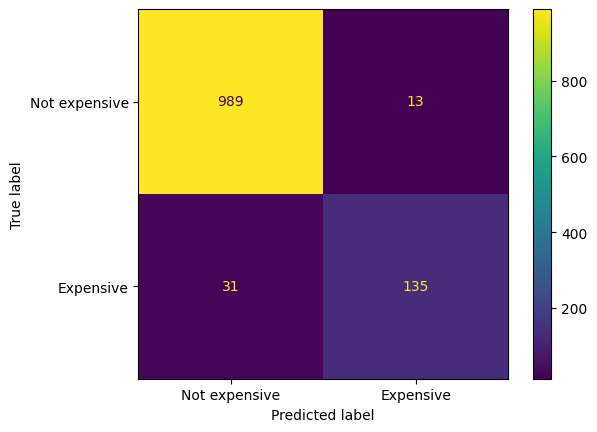

In [200]:
ConfusionMatrixDisplay.from_estimator(
    best_lr
    , X_train
    , y_train
    , display_labels=['Not expensive', 'Expensive']);

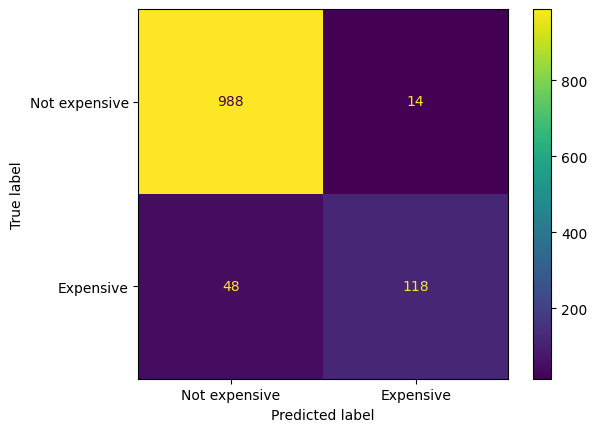

In [201]:
ConfusionMatrixDisplay.from_estimator(
    best_knn
    , X_train
    , y_train
    , display_labels=['Not expensive', 'Expensive']);

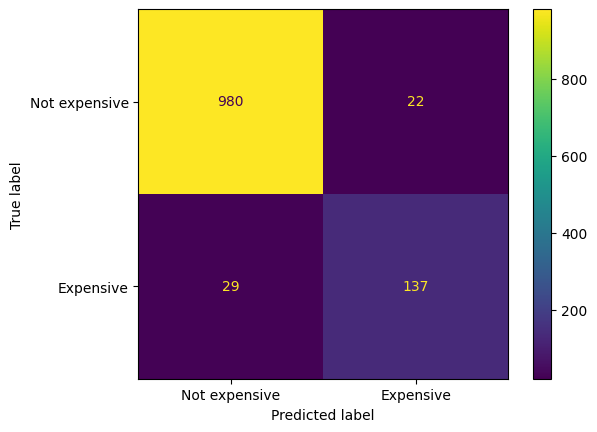

In [202]:
ConfusionMatrixDisplay.from_estimator(
    best_svc
    , X_train
    , y_train
    , display_labels=['Not expensive', 'Expensive']);

### Test

In [203]:
y_test_pred_rf = best_rf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_rf):.4f}')
print(f'Recall: {recall_score(y_test, y_test_pred_rf):.4f}')
print(f'Precision: {precision_score(y_test, y_test_pred_rf):.4f}')
print(f'F1 score: {f1_score(y_test, y_test_pred_rf):.4f}')

Accuracy: 0.9452
Recall: 0.7255
Precision: 0.9487
F1 score: 0.8222


In [204]:
y_test_pred_dt = best_dt.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_dt):.4f}')
print(f'Recall: {recall_score(y_test, y_test_pred_dt):.4f}')
print(f'Precision: {precision_score(y_test, y_test_pred_dt):.4f}')
print(f'F1 score: {f1_score(y_test, y_test_pred_dt):.4f}')

Accuracy: 0.9178
Recall: 0.7059
Precision: 0.8000
F1 score: 0.7500


In [205]:
y_test_pred_lr = best_lr.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_lr):.4f}')
print(f'Recall: {recall_score(y_test, y_test_pred_lr):.4f}')
print(f'Precision: {precision_score(y_test, y_test_pred_lr):.4f}')
print(f'F1 score: {f1_score(y_test, y_test_pred_lr):.4f}')

Accuracy: 0.9452
Recall: 0.7843
Precision: 0.8889
F1 score: 0.8333


In [206]:
y_test_pred_knn = best_knn.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_knn):.4f}')
print(f'Recall: {recall_score(y_test, y_test_pred_knn):.4f}')
print(f'Precision: {precision_score(y_test, y_test_pred_knn):.4f}')
print(f'F1 score: {f1_score(y_test, y_test_pred_knn):.4f}')

Accuracy: 0.9247
Recall: 0.7255
Precision: 0.8222
F1 score: 0.7708


In [207]:
y_test_pred_svc = best_svc.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_svc):.4f}')
print(f'Recall: {recall_score(y_test, y_test_pred_svc):.4f}')
print(f'Precision: {precision_score(y_test, y_test_pred_svc):.4f}')
print(f'F1 score: {f1_score(y_test, y_test_pred_svc):.4f}')

Accuracy: 0.9041
Recall: 0.7255
Precision: 0.7255
F1 score: 0.7255


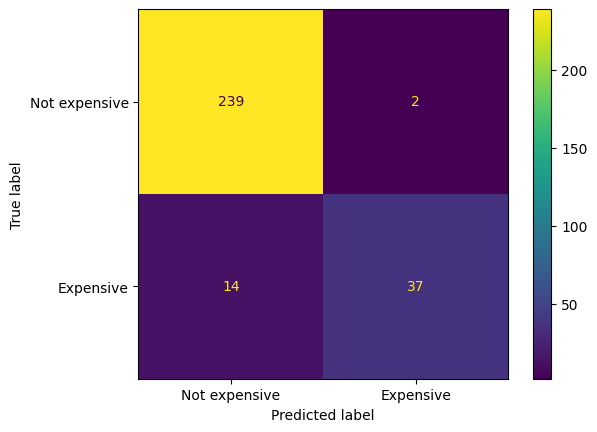

In [208]:
ConfusionMatrixDisplay.from_estimator(
    best_rf
    , X_test
    , y_test
    , display_labels=['Not expensive', 'Expensive']);

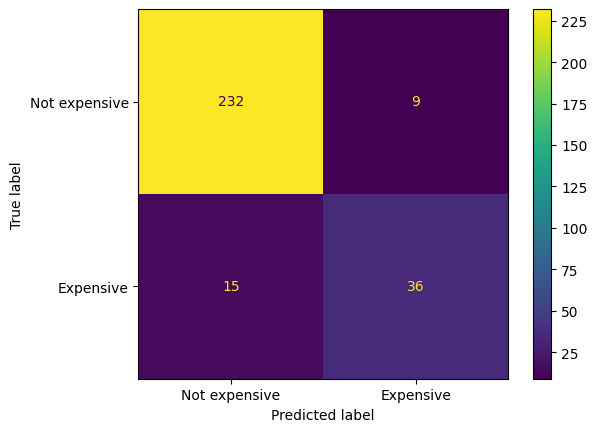

In [209]:
ConfusionMatrixDisplay.from_estimator(
    best_dt
    , X_test
    , y_test
    , display_labels=['Not expensive', 'Expensive']);

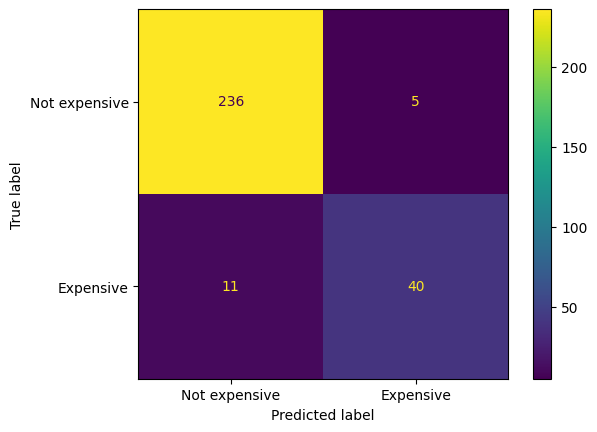

In [210]:
ConfusionMatrixDisplay.from_estimator(
    best_lr
    , X_test
    , y_test
    , display_labels=['Not expensive', 'Expensive']);

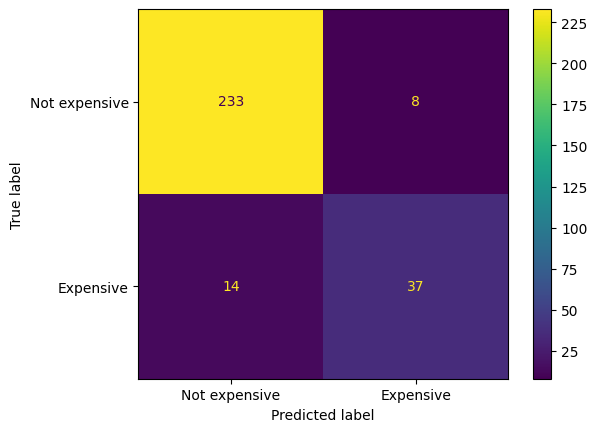

In [211]:
ConfusionMatrixDisplay.from_estimator(
    best_knn
    , X_test
    , y_test
    , display_labels=['Not expensive', 'Expensive']);

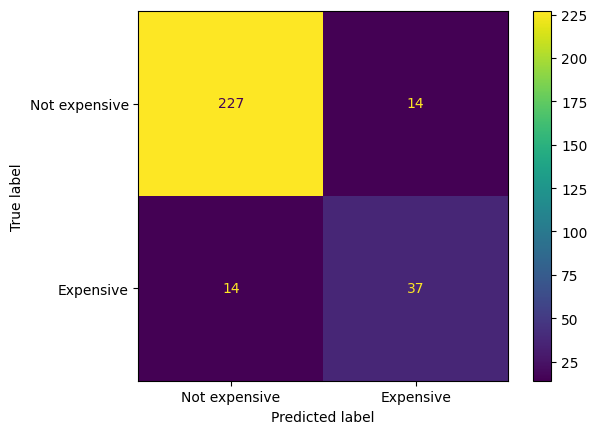

In [212]:
ConfusionMatrixDisplay.from_estimator(
    best_svc
    , X_test
    , y_test
    , display_labels=['Not expensive', 'Expensive']);

### Competition test

#### Training

In [213]:
data_competition

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,MSZoning,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,11622,80.0,882.0,2,0,0,1.0,140,120,RH,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1462,14267,81.0,1329.0,3,0,0,1.0,393,0,RL,...,Attchd,Unf,TA,TA,Y,NaN,NaN,Gar2,WD,Normal
1463,13830,74.0,928.0,3,1,0,2.0,212,0,RL,...,Attchd,Fin,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1464,9978,78.0,926.0,3,1,0,2.0,360,0,RL,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1465,5005,43.0,1280.0,2,0,0,2.0,0,144,RL,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,1936,21.0,546.0,3,0,0,0.0,0,0,RM,...,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,WD,Normal
2916,1894,21.0,546.0,3,0,0,1.0,0,0,RM,...,CarPort,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
2917,20000,160.0,1224.0,4,1,0,2.0,474,0,RL,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml


In [214]:
y_competition_pred_rf = best_rf.predict(X_data_competition)
data_competition['Expensive_rf'] = y_competition_pred_rf

In [215]:
y_competition_pred_dt = best_dt.predict(X_data_competition)
data_competition['Expensive_dt'] = y_competition_pred_dt

In [216]:
y_competition_pred_lr = best_lr.predict(X_data_competition)
data_competition['Expensive_lr'] = y_competition_pred_lr

In [217]:
y_competition_pred_knn = best_knn.predict(X_data_competition)
data_competition['Expensive_knn'] = y_competition_pred_knn

In [218]:
y_competition_pred_svc = best_svc.predict(X_data_competition)
data_competition['Expensive_svc'] = y_competition_pred_svc

In [219]:
data_competition.columns

Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSZoning',
       'Condition1', 'Heating', 'Street', 'CentralAir', 'Foundation',
       'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'KitchenQual', 'FireplaceQu', 'MSSubClass',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'MiscVal', 'MoSold',
       'YrSold', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'BsmtFinType2',

In [225]:
accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
accuracy_dt = accuracy_score(y_test, y_test_pred_dt)
accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
accuracy_svc = accuracy_score(y_test, y_test_pred_svc)

In [232]:

data_competition['Expensive_rf'] * accuracy_rf

Id
1461    0.0
1462    0.0
1463    0.0
1464    0.0
1465    0.0
       ... 
2915    0.0
2916    0.0
2917    0.0
2918    0.0
2919    0.0
Name: Expensive_rf, Length: 1459, dtype: float64

In [233]:
accuracies = [accuracy_rf, accuracy_dt, accuracy_lr, accuracy_knn, accuracy_svc]
normalized_weights = [acc / sum(accuracies) for acc in accuracies]

dfs = pd.concat([
    data_competition['Expensive_rf'] * accuracy_rf
    , data_competition['Expensive_dt'] * accuracy_dt
    , data_competition['Expensive_lr'] * accuracy_lr
    , data_competition['Expensive_knn'] * accuracy_knn
    , data_competition['Expensive_svc'] * accuracy_svc
    ], axis=1)

#weighted_predictions = sum(dfs.iloc[:, j] * normalized_weights[j] for j in range(len(dfs)))
result = dfs.mean(axis=1).round().astype(int)
result_df = pd.DataFrame({'Expensive': result})

In [237]:
try:
    i += 1
except NameError:
    i = 1
# data_competition['Expensive'].to_csv(f'data/submission_{i}_{accuracy_score(y_test, y_test_pred):4f}_.csv')
result_df.to_csv(f'data/submission_{i}_1_.csv')

In [236]:
i

4